# OISST Timeseries - NMFS Trawl Regions

**ABOUT:**
Now that there exist climatologies and anomalies from those climate means the last product is then an application of those approaches, but within the scope of a specific area. For these we want to know what the average temperature was across a specific group of pixels defined by a polygon of interest. From those regional climatologies we can get timelines of temperature anomalies, their variance, and their likelihood with a regional scope.

## Product 4. OISST Regional Timeseries


**Objective: Calculate full sea surface temperature histories for the NMFS trawl regions (Georges Bank, Gulf of Maine, Southern New England, Mid-Atlantic Bight)**


In [1]:
# Load Packages
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import os
import geopandas as gpd
import regionmask
import math

# #ensure we're in correct directory for OISST Data
# os.chdir("/home/jovyan/NSF OKN Demo Data")

## Step 1: Load the NMFS Regions

The following regions are composites of various strata from the [Northeast Groundfish Trawl Survey](https://www.fisheries.noaa.gov/region/new-england-mid-atlantic)

The region shapes being loaded were created in R using the following allocations:

"Southern New England"  = strata 01:12   
"Georges Bank"          = strata 13:23   
"Gulf of Maine"         = strata 24:40   
"Mid-Atlantic Bight"    = strata 61:76   

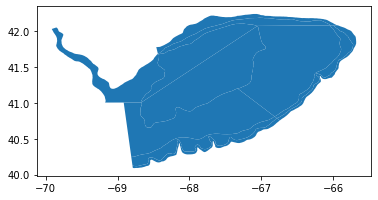

In [4]:
# Load trawl regions - created in R code, https://github.com/adamkemberling/nefsc_trawl/blob/master/R/10_nefsc_regional_polys.R
trawl_area_paths = {
    "Georges Bank"         : "NMFS_trawl_regions/nmfs_trawl_georges_bank.geojson",
    "Gulf of Maine"        : "NMFS_trawl_regions/nmfs_trawl_gulf_of_maine.geojson",
    "Southern New England" : "NMFS_trawl_regions/nmfs_trawl_southern_new_england.geojson",
    "Mid-Atlantic Bight"   : "NMFS_trawl_regions/nmfs_trawl_mid_atlantic_bight.geojson"}

trawl_area_info = pd.DataFrame.from_dict(trawl_area_paths, orient = "index", columns = ["path"])
trawl_area_info = trawl_area_info.reset_index().rename(columns = {"index": "area"})

# Load polygons
trawl_areas = []
for i, area_path in trawl_area_info.iterrows():
    shape = gpd.read_file(area_path.path)
    trawl_areas.append(shape)

# Plot a single area - Georges Bank
trawl_areas[0].plot()

## Step 2: Load OISST Collection

Timelines for these area haven't been calculates yet so it should be possible to do the full thing all at once. Steps are to load the observed data, get what the mean sst is for every day as a timeseries, as well as what the climatology is for that day of the year.

In [5]:
# Append netcdf paths together
fpaths = []
for yr in range(1981, 2020 + 1):
    fpaths.append(f'NSF OKN Demo Data/oisst/annual_observations/sst.day.mean.{yr}.v2.nc')

# Lazy-load the data itself using xr.open_mfdataset
oisst = xr.open_mfdataset(fpaths, combine = "by_coords", parallel = False)
oisst


# Add modified ordinal day, for day-to-day calculation and leapyear adjustment
not_leap_year = oisst.indexes['time'].is_leap_year
march_or_later = oisst.time.dt.month >= 3
ordinal_day = oisst.time.dt.dayofyear
modified_ordinal_day = ordinal_day + (not_leap_year & march_or_later)

# Assign MOD coordinate
oisst = oisst.assign_coords(modified_ordinal_day = modified_ordinal_day)
oisst

<xarray.Dataset>
Dimensions:               (lat: 720, lon: 1440, time: 14321)
Coordinates:
  * lon                   (lon) float32 0.125 0.375 0.625 ... 359.625 359.875
  * lat                   (lat) float32 -89.875 -89.625 ... 89.625 89.875
  * time                  (time) datetime64[ns] 1981-09-01 ... 2020-11-15
    modified_ordinal_day  (time) int64 244 245 246 247 248 ... 318 319 320 321
Data variables:
    sst                   (time, lat, lon) float32 dask.array<chunksize=(122, 720, 1440), meta=np.ndarray>
Attributes:
    Conventions:    CF-1.5
    title:          NOAA High-resolution Blended Analysis: Daily Values using...
    institution:    NOAA/NCDC
    source:         NOAA/NCDC  ftp://eclipse.ncdc.noaa.gov/pub/OI-daily-v2/
    comment:        Reynolds, et al., 2007: Daily High-Resolution-Blended Ana...
    history:        Thu Aug 24 13:34:17 2017: ncatted -O -a References,global...
    references:     https://www.esrl.noaa.gov/psd/data/gridded/data.noaa.oiss...
    dataset_title:  NOAA Daily Optimum Interpolation Sea Surface Temperature

## Step 3: Load OISST Climatology

From the global extent climatology we will want to get regional means for the areas of interest.

In [8]:
# Load the OISST Climatology
oisst_clim = xr.open_dataset('NSF OKN Demo Data/oisst/daily_climatologies/daily_clims_82to2011.nc')
oisst_clim

<xarray.Dataset>
Dimensions:               (lat: 720, lon: 1440, modified_ordinal_day: 366)
Coordinates:
  * lat                   (lat) float32 -89.875 -89.625 ... 89.625 89.875
  * lon                   (lon) float32 0.125 0.375 0.625 ... 359.625 359.875
  * modified_ordinal_day  (modified_ordinal_day) int64 1 2 3 4 ... 364 365 366
Data variables:
    sst                   (modified_ordinal_day, lat, lon) float32 ...

## Step 4: Create Masked Timeseries

So the steps to create a masked timeseries are straightforward. Once everything is prepped you simply create a mask with the geometry of the polygon of interest. You then extract the cells that fall within it, and calculatet the mean temperature and standard deviation for the area for each time step. These steps are repeated for the raw observations as well as the climate means in order to get anomalies from the 82-2011 climatology.

In [9]:
# list to store them un-appended
new_ts = []

##### Super loop for all the LME's  ####
for i, area in trawl_area_info.iterrows():
    
    # naming convention from sct.regional_anom_likelihoods
    parent_gname = "OISSTv2"
    grid_ds = oisst
    clim_ds = oisst_clim
    
    # Grab the shape object the we are looping through
    shp_obj = trawl_areas[i] 
    shp_name = area["area"]
    poly_name = area["area"].replace(" ", "_").lower()  
    var_name = "sst"
    
    
    
    ##
    # 1. Calculate Mu and Sigma from climatology for area within polygon
    ##

    # a. Set up naming convention for var of interest
    clim_name = f"{var_name}_clim"
    sd_name   = f"clim_sd"

    # b. Make the mask
    area_mask = regionmask.Regions(shp_obj.geometry,
                                   name = shp_name)

    # c. Mask the array to get nan test
    mask = area_mask.mask(clim_ds, lon_name = "lon", lat_name = "lat")

    # d. Extract data that falls within the mask
    masked_ds = clim_ds.where(~np.isnan(mask))

    # e. Calculate timeseries mean and sd
    masked_ts = getattr(masked_ds, var_name).mean(dim = ("lat", "lon"))#
    masked_ts[f"{sd_name}"] = getattr(masked_ds, var_name).std(dim = ("lat", "lon"))


    # f. Format masked timeseries dataframe
    regional_climatology = masked_ts.to_dataframe()
    regional_climatology = regional_climatology.reset_index()
    regional_climatology = regional_climatology.rename(columns = {f"{var_name}" : f"{clim_name}"})
    


    ##
    # 2. Calculate Mean Var Timeline from Observed Data for Area Within Polygon
    ##


    # a. Make the mask
    area_mask = regionmask.Regions(shp_obj.geometry,
                                   name = shp_name)

    # b. Mask the array with gom_mask to get nan test
    mask = area_mask.mask(grid_ds, lon_name = "lon", lat_name = "lat")

    # c. Extract data that falls within the mask
    masked_ds = grid_ds.where(~np.isnan(mask))

    # d. Calculate timeseries mean and sd
    masked_ts = getattr(masked_ds, var_name).mean(dim = ("lat", "lon"))


    # e. Masked Timeseries Dataframe
    regional_means = masked_ts.to_dataframe()
    regional_means = regional_means.reset_index()
    regional_means["time"] = pd.to_datetime(regional_means["time"])

    # f. Set up MOD for matching climatology
    #regional_means['month'] = pd.DatetimeIndex(regional_means['time']).month


    ##
    # 3. Log-Likelihood Estimate
    ##

    # Merge on MOD
    anom_timeline = regional_means.merge(regional_climatology, how = "left", on = "modified_ordinal_day")

    #Set index as the date
    anom_timeline.index = anom_timeline.index = anom_timeline["time"]
    anom_timeline = anom_timeline.drop(["time"], axis = 1)

    #Calc anoms
    anom_timeline = anom_timeline.assign(anom = anom_timeline[f"{var_name}"] - anom_timeline[f"{clim_name}"])
    anom_timeline = anom_timeline.rename(columns = { "anom" : f"{var_name}_anom"})

    # get likelihood
    def calc_ll(row):
        # log likelihood 
        n = 1
        anom  = row[f"{var_name}"]
        sigma = row["clim_sd"]
        mu    = row[f"{clim_name}"]
        log_lik = n * math.log(2 * math.pi * (sigma ** 2)) / 2 + np.sum(((anom - mu) ** 2) / (2 * (sigma ** 2)))
        return log_lik

    #anom_timeline.apply(llnorm, axis = 1, args = anom_timeline[["sst_clim", "clim_sd", "sst_anom"]])
    anom_timeline["log_lik"] = anom_timeline.apply(calc_ll, axis = 1)
    anom_timeline = anom_timeline.reset_index()
    
    # re-order columns for peace of mind
    anom_timeline = anom_timeline[["time", "modified_ordinal_day", "sst", "sst_clim", "sst_anom", "clim_sd", "log_lik"]]
    
    # add to list
    new_ts.append(anom_timeline)

## Validation: Table inspection and Plot

In [12]:
new_ts[0].head()

,time,modified_ordinal_day,sst,clim_sd,sst_clim,sst_anom,log_lik
0,1981-09-01,244,17.208355,1.374129,17.939363,-0.731009,1.378260
1,1981-09-02,245,17.087124,1.334107,17.858522,-0.771399,1.374366
2,1981-09-03,246,16.414795,1.334335,17.819725,-1.404930,1.761678
3,1981-09-04,247,15.689451,1.354890,17.799932,-2.110481,2.435838
4,1981-09-05,248,15.607397,1.327617,17.748188,-2.140791,2.502413


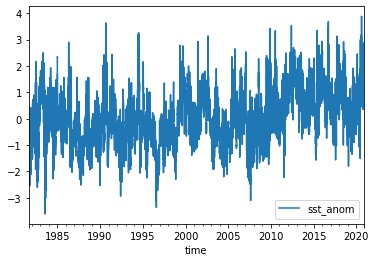

In [13]:
new_ts[0].plot("time", "sst_anom")

## Step 5: Export

In [14]:

##### Super loop for all the LME's  ####
for i, area in trawl_area_info.iterrows():
    
    # naming convention from sct.regional_anom_likelihoods
    parent_gname = "OISSTv2"
    mask_name = area["area"].replace(" ", "_").lower()  # name of the mask area
    out_folder = "NSF OKN Demo Data/oisst/regional_timeseries/nmfs_trawl_regions"
    grid_name = "OISSTv2_anom"
    
    # Path to the timeseries
    out_path = f"{out_folder}/{grid_name}_{mask_name}.csv"
    
    # And export
    new_ts[i].to_csv(out_path, index = False)